In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [175]:
def remove_duplicates(lst):
    seen = set()
    seen_add = seen.add
    return [x for x in lst if not (x in seen or seen_add(x))]

def group(lst):
    grouped_bets = []
    iteration = 0
    for index in range(len(lst)/3):
        grouped_bets.append((bet_houses[index], (lst[iteration*3], lst[iteration*3 + 1], lst[iteration*3 + 2])))
        iteration += 1
    return grouped_bets

bets_csv_file = sc.textFile("/home/gg6/BetsExploring/Data/Raw/Main/Spain/Primera_1718.csv")

bet_houses = remove_duplicates(bets_csv_file.map(lambda line: line.split(","))\
        .map(lambda line : map(lambda bet_house : bet_house[:-1], line[22:43])).take(1)[0])

bets = bets_csv_file.map(lambda line: line.split(","))\
        .filter(lambda line : line[0] != "Div").map(lambda line: (line[6], group(line[22:43])))

print("\nBet houses -> " + str(bet_houses))
print("\nBets by house -> " + str(bets.take(5)))


Bet houses -> [u'B365', u'BW', u'IW', u'LB', u'PS', u'WH', u'VC']

Bets by house -> [(u'H', [(u'B365', (u'2.05', u'3.2', u'4.1')), (u'BW', (u'2.05', u'3.1', u'4.1')), (u'IW', (u'2.1', u'3.4', u'3.5')), (u'LB', (u'2.05', u'3', u'4.2')), (u'PS', (u'2.03', u'3.25', u'4.52')), (u'WH', (u'2.05', u'3.1', u'4')), (u'VC', (u'2.05', u'3.2', u'4.4'))]), (u'H', [(u'B365', (u'1.75', u'3.8', u'4.5')), (u'BW', (u'1.75', u'3.9', u'4.6')), (u'IW', (u'1.75', u'3.6', u'4.8')), (u'LB', (u'1.75', u'3.8', u'4.33')), (u'PS', (u'1.78', u'4.01', u'4.83')), (u'WH', (u'1.8', u'3.75', u'4.2')), (u'VC', (u'1.8', u'4', u'4.6'))]), (u'A', [(u'B365', (u'2.38', u'3.25', u'3.2')), (u'BW', (u'2.4', u'3.3', u'3')), (u'IW', (u'2.5', u'3.3', u'2.85')), (u'LB', (u'2.35', u'3.25', u'3')), (u'PS', (u'2.44', u'3.4', u'3.16')), (u'WH', (u'2.4', u'3.4', u'2.9')), (u'VC', (u'2.4', u'3.4', u'3.13'))]), (u'D', [(u'B365', (u'8', u'4.33', u'1.45')), (u'BW', (u'7.5', u'4.33', u'1.45')), (u'IW', (u'7.2', u'4.4', u'1.45')), (u'LB', (u

In [176]:
def bets_mean(bets):
    total_bets = len(bets)
    mean_home = 0.0
    mean_draw = 0.0
    mean_away = 0.0
    
    for bet in bets:
        try:
            mean_home += float(bet[1][0])
            mean_draw += float(bet[1][1])
            mean_away += float(bet[1][2])
        except:
            pass
    mean_home = mean_home / total_bets
    mean_draw = mean_draw / total_bets
    mean_away = mean_away / total_bets
    
    return(mean_home, mean_draw, mean_away)
    
bets_with_mean = bets.map(lambda line : (line[0], bets_mean(line[1]), line[1]))

print("Bets with mean -> " + str(bets_with_mean.take(5)))
    

Bets with mean -> [(u'H', (2.0542857142857143, 3.1785714285714284, 4.117142857142857), [(u'B365', (u'2.05', u'3.2', u'4.1')), (u'BW', (u'2.05', u'3.1', u'4.1')), (u'IW', (u'2.1', u'3.4', u'3.5')), (u'LB', (u'2.05', u'3', u'4.2')), (u'PS', (u'2.03', u'3.25', u'4.52')), (u'WH', (u'2.05', u'3.1', u'4')), (u'VC', (u'2.05', u'3.2', u'4.4'))]), (u'H', (1.7685714285714287, 3.837142857142857, 4.551428571428571), [(u'B365', (u'1.75', u'3.8', u'4.5')), (u'BW', (u'1.75', u'3.9', u'4.6')), (u'IW', (u'1.75', u'3.6', u'4.8')), (u'LB', (u'1.75', u'3.8', u'4.33')), (u'PS', (u'1.78', u'4.01', u'4.83')), (u'WH', (u'1.8', u'3.75', u'4.2')), (u'VC', (u'1.8', u'4', u'4.6'))]), (u'A', (2.4099999999999997, 3.3285714285714283, 3.0342857142857143), [(u'B365', (u'2.38', u'3.25', u'3.2')), (u'BW', (u'2.4', u'3.3', u'3')), (u'IW', (u'2.5', u'3.3', u'2.85')), (u'LB', (u'2.35', u'3.25', u'3')), (u'PS', (u'2.44', u'3.4', u'3.16')), (u'WH', (u'2.4', u'3.4', u'2.9')), (u'VC', (u'2.4', u'3.4', u'3.13'))]), (u'D', (7.72

In [189]:
curious_ratio = 1.25

def evaluate_bets_over_mean(line):
    curious_home_bets = []
    curious_draw_bets = []
    curious_away_bets = []
    
    for bet in line[2]:
        try:
            if(float(bet[1][0]) >= line[1][0] * curious_ratio):
                curious_home_bets.append(bet[0])
            if(float(bet[1][1]) >= line[1][1] * curious_ratio):
                curious_draw_bets.append(bet[0])
            if(float(bet[1][2]) >= line[1][2] * curious_ratio):
                curious_away_bets.append(bet[0])
        except:
            pass
        
    return (curious_home_bets, curious_draw_bets, curious_away_bets)

curious_bets = bets_with_mean.map(lambda line : (line[0], evaluate_bets_over_mean(line)))
print("Bets over mean -> " + str(curious_bets.collect()))

Bets over mean -> [(u'H', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'D', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [u'VC'])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'D', (

In [190]:
def evaluate_bets_under_mean(line):
    curious_home_bets = []
    curious_draw_bets = []
    curious_away_bets = []
    
    for bet in line[2]:
        try:
            if(float(bet[1][0]) <= line[1][0] / curious_ratio):
                curious_home_bets.append(bet[0])
            if(float(bet[1][1]) <= line[1][1] / curious_ratio):
                curious_draw_bets.append(bet[0])
            if(float(bet[1][2]) <= line[1][2] / curious_ratio):
                curious_away_bets.append(bet[0])
        except:
            pass
        
    return (curious_home_bets, curious_draw_bets, curious_away_bets)

curious_bets = bets_with_mean.map(lambda line : (line[0], evaluate_bets_under_mean(line)))
print("Bets under mean -> " + str(curious_bets.collect()))

Bets under mean -> [(u'H', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'D', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'A', ([u'IW'], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'A', ([u'IW'], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'D', ([], [u'IW'], [u'WH'])), (u'H', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [u'IW'])), (u'H', ([], [], [])), (u'A', ([u'IW'], [], [])), (u'D', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [u'B365', u'BW'])), (u'H', ([], [], [])), (u'A', ([], 

In [187]:
def maximum_bets(line):
    home_maximum = ("", 0.0)
    draw_maximum = ("", 0.0)
    away_maximum = ("", 0.0)
    
    for bet in line[1]:
        try:
            if(float(bet[1][0]) > home_maximum[1]):
                home_maximum = (bet[0], float(bet[1][0]))
            if(float(bet[1][1]) > draw_maximum[1]):
                draw_maximum = (bet[0], float(bet[1][1]))
            if(float(bet[1][2]) > away_maximum[1]):
                away_maximum = (bet[0], float(bet[1][2]))
        except:
            pass
    
    return (home_maximum, draw_maximum, away_maximum)

print("Maximum bets -> " + str(bets.map(lambda line: (line[0], maximum_bets(line))).take(10)))

Maximum bets -> [(u'H', ((u'IW', 2.1), (u'IW', 3.4), (u'PS', 4.52))), (u'H', ((u'WH', 1.8), (u'PS', 4.01), (u'PS', 4.83))), (u'A', ((u'IW', 2.5), (u'PS', 3.4), (u'B365', 3.2))), (u'D', ((u'PS', 8.36), (u'IW', 4.4), (u'LB', 1.5))), (u'D', ((u'WH', 1.67), (u'PS', 4.17), (u'IW', 6.2))), (u'D', ((u'PS', 1.53), (u'PS', 4.37), (u'B365', 7.5))), (u'H', ((u'PS', 1.22), (u'B365', 8.0), (u'PS', 15.5))), (u'A', ((u'WH', 11.0), (u'PS', 5.79), (u'IW', 1.35))), (u'H', ((u'PS', 3.36), (u'IW', 3.35), (u'WH', 2.4))), (u'A', ((u'PS', 2.24), (u'IW', 3.4), (u'B365', 3.7)))]


In [188]:
def minimum_bets(line):
    home_minimum = ("", 99.0)
    draw_minimum = ("", 99.0)
    away_minimum = ("", 99.0)
    
    for bet in line[1]:
        try:
            if(float(bet[1][0]) < home_minimum[1]):
                home_minimum = (bet[0], float(bet[1][0]))
            if(float(bet[1][1]) < draw_minimum[1]):
                draw_minimum = (bet[0], float(bet[1][1]))
            if(float(bet[1][2]) < away_minimum[1]):
                away_minimum = (bet[0], float(bet[1][2]))
        except:
            pass
    
    return (home_minimum, draw_minimum, away_minimum)

print("Minimum bets -> " + str(bets.map(lambda line: (line[0], minimum_bets(line))).take(10)))

Minimum bets -> [(u'H', ((u'PS', 2.03), (u'LB', 3.0), (u'IW', 3.5))), (u'H', ((u'B365', 1.75), (u'IW', 3.6), (u'WH', 4.2))), (u'A', ((u'LB', 2.35), (u'B365', 3.25), (u'IW', 2.85))), (u'D', ((u'IW', 7.2), (u'LB', 4.0), (u'WH', 1.44))), (u'D', ((u'IW', 1.55), (u'WH', 3.6), (u'B365', 5.5))), (u'D', ((u'BW', 1.48), (u'B365', 4.0), (u'IW', 6.5))), (u'H', ((u'B365', 1.17), (u'WH', 6.0), (u'WH', 13.0))), (u'A', ((u'IW', 7.5), (u'WH', 4.5), (u'B365', 1.3))), (u'H', ((u'WH', 3.1), (u'LB', 3.1), (u'IW', 2.2))), (u'A', ((u'B365', 2.1), (u'LB', 3.1), (u'WH', 3.3)))]


In [201]:
def bets_hit(line):
    hit = []
    
    for bet in line[1]:
        try:
            if(line[0] == "H"):
                if(float(bet[1][0]) < float(bet[1][1]) and float(bet[1][0]) < float(bet[1][2])):
                   hit.append((bet[0], (1, 0)))
                else:
                   hit.append((bet[0], (0, 1)))
            if(line[0] == "D"):
                if(float(bet[1][1]) < float(bet[1][0]) and float(bet[1][1]) < float(bet[1][2])):
                   hit.append((bet[0], (1, 0)))
                else:
                   hit.append((bet[0], (0, 1)))
            if(line[0] == "A"):
                if(float(bet[1][2]) < float(bet[1][0]) and float(bet[1][2]) < float(bet[1][1])):
                   hit.append((bet[0], (1, 0)))
                else:
                   hit.append((bet[0], (0, 1)))
        except:
            pass
    return hit

hit_ratio = bets.flatMap(lambda line : bets_hit(line)).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

print("\nHit ratio -> " + str(hit_ratio.collect()))

print("\nTotal bets -> " + str(hit_ratio.map(lambda x: (x[0], x[1][0] + x[1][1])).collect()))

hit_rate = hit_ratio.map(lambda x: (x[0], float(x[1][0]) / float(x[1][0] + x[1][1])))

print("\nHit rate -> " + str(hit_rate.collect()))


Hit ratio -> [(u'B365', (208, 172)), (u'LB', (208, 171)), (u'IW', (205, 175)), (u'BW', (208, 172)), (u'PS', (209, 171)), (u'VC', (208, 172)), (u'WH', (206, 174))]

Total bets -> [(u'B365', 380), (u'LB', 379), (u'IW', 380), (u'BW', 380), (u'PS', 380), (u'VC', 380), (u'WH', 380)]

Hit rate -> [(u'B365', 0.5473684210526316), (u'LB', 0.5488126649076517), (u'IW', 0.5394736842105263), (u'BW', 0.5473684210526316), (u'PS', 0.55), (u'VC', 0.5473684210526316), (u'WH', 0.5421052631578948)]


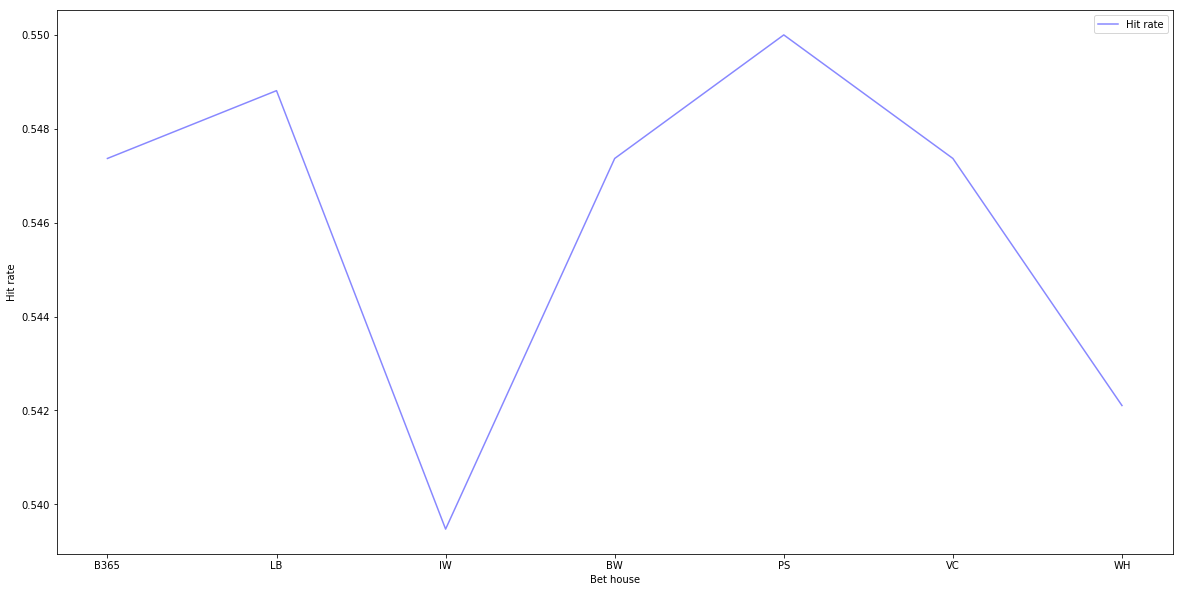

In [207]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.plot(hit_rate.keys().collect(), hit_rate.values().collect(), "#8888ff", label="Hit rate")
plt.xlabel("Bet house")
plt.ylabel("Hit rate")
plt.legend()